In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import fcluster
import faiss
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('dailykos.csv')
data=df.to_numpy()

In [3]:
d=data.shape[1]
N=data.shape[0]
index=faiss.IndexFlatL2(d)
index.add(data)    
D,I=index.search(data,N+1)   # find the 101 nearest neighbors
I,D=np.delete(I, 0, 1),np.delete(D, 0, 1)      # remove the 1st nearest neighbor (Each point's first nearest neighbor is itself)

In [4]:
dist=1-cosine_similarity(df)

# Heirarchical Clustering

In [5]:
ward_linkage_matrix=ward(dist) 

In [6]:
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(ward_linkage_matrix, orientation="right")


plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.close()

### Using three clusters

In [13]:
nClusters=3

ward_clusters = fcluster(
    ward_linkage_matrix, 
    nClusters, 
    criterion='maxclust'
)
# add WARD results
df['ward_cluster']=ward_clusters

In [14]:
clusters=df['ward_cluster'].unique()
clusterTerms=pd.DataFrame(columns=clusters)
for cluster in clusters:
    indices=np.where(df['ward_cluster']==cluster)[0]
    # Look at all the columns(terms) excluding the last one which contains cluster labels
    termSums=np.sum(df.iloc[indices,:-1],axis=0)
    sortedSums=termSums.sort_values(ascending=False)
    clusterTerms[cluster]=sortedSums.keys()
    clusterTerms[str(cluster)+' frequency']=sortedSums.values

In [15]:
# Look at the terms and exlude the frequencies
clusterTerms.iloc[:10,:len(clusters)]

,3,1,2
0,democrat,november,bush
1,bush,poll,kerry
2,kerry,vote,poll
3,state,challenge,presided
4,republican,bush,democrat
5,poll,democrat,campaign
6,elect,republican,state
7,dean,house,general
8,iraq,senate,iraq
9,campaign,kerry,time


### Using 7 clusters

In [16]:
nClusters=7
ward_clusters = fcluster(
    ward_linkage_matrix, 
    nClusters, 
    criterion='maxclust'
)
# add WARD results
df['ward_cluster'] = ward_clusters

In [17]:
clusters=df['ward_cluster'].unique()
clusterTerms=pd.DataFrame(columns=clusters)
for cluster in clusters:
    indices=np.where(df['ward_cluster']==cluster)[0]
    # Look at all the columns(terms) excluding the last one which contains cluster labels
    termSums=np.sum(df.iloc[indices,:-1],axis=0)
    sortedSums=termSums.sort_values(ascending=False)
    clusterTerms[cluster]=sortedSums.keys()
    clusterTerms[str(cluster)+' frequency']=sortedSums.values

In [18]:
# Look at the terms and exclude the frequencies
clusterTerms.iloc[:10,:len(clusters)]

,5,7,1,4,3,2,6
0,bush,dean,november,state,bush,bush,democrat
1,iraq,kerry,poll,time,kerry,kerry,republican
2,war,poll,vote,elect,presided,poll,senate
3,administration,democrat,challenge,republican,campaign,percent,state
4,presided,edward,bush,general,iraq,voter,elect
5,american,primaries,democrat,political,democrat,general,parties
6,report,clark,republican,people,war,state,race
7,time,campaign,house,democrat,state,vote,candidate
8,iraqi,iowa,senate,media,republican,democrat,campaign
9,official,gephardt,kerry,house,general,presided,house


In [19]:
df['ward_cluster'].value_counts()

5    782
4    637
7    528
6    501
3    408
1    329
2    245
Name: ward_cluster, dtype: int64

### Getting average term frequency

In [20]:
clusters=df['ward_cluster'].unique()
clusterAvgFreq=pd.DataFrame(columns=clusters)
for cluster in clusters:
    indices=np.where(df['ward_cluster']==cluster)[0]
    n=len(indices)
    # Look at all the columns(terms) excluding the last one which contains cluster labels
    avgFreqs=np.sum(df.iloc[indices,:-1],axis=0)/n
    sorteAvgs=avgFreqs.sort_values(ascending=False)
    clusterAvgFreq[cluster]=sorteAvgs.keys()
    clusterAvgFreq[str(cluster)+' frequency']=sorteAvgs.values

In [21]:
clusterAvgFreq.iloc[:6,:len(clusters)]

,5,7,1,4,3,2,6
0,bush,dean,november,state,bush,bush,democrat
1,iraq,kerry,poll,time,kerry,kerry,republican
2,war,poll,vote,elect,presided,poll,senate
3,administration,democrat,challenge,republican,campaign,percent,state
4,presided,edward,bush,general,iraq,voter,elect
5,american,primaries,democrat,political,democrat,general,parties


In [22]:
clusterAvgFreq.iloc[:6,len(clusters):]

,5 frequency,7 frequency,1 frequency,4 frequency,3 frequency,2 frequency,6 frequency
0,2.291560,2.901515,10.370821,0.635793,7.156863,5.273469,3.453094
1,1.814578,2.856061,4.841945,0.533752,3.051471,4.644898,2.487026
2,1.464194,2.176136,4.443769,0.524333,1.634804,4.114286,1.820359
3,1.170077,1.598485,4.118541,0.453689,1.372549,1.383673,1.720559
4,0.898977,1.435606,3.039514,0.416013,1.235294,1.302041,1.718563
5,0.869565,1.344697,2.887538,0.411303,1.188725,1.122449,1.698603


# K Means Clustering

In [23]:
km_num_clusters=7

#n_init Number of times the k-means algorithm is run with different centroid seeds
km=KMeans(n_clusters=km_num_clusters, n_init = 10, random_state=1000)
km_clusters=km.fit_predict(dist)
df['km_cluster']=km_clusters

In [24]:
df['km_cluster'].value_counts()

3    787
6    650
0    505
5    444
2    397
4    324
1    323
Name: km_cluster, dtype: int64

In [25]:
clusters=df['km_cluster'].unique()
kMclusterAvgFreq=pd.DataFrame(columns=clusters)
for cluster in clusters:
    indices=np.where(df['km_cluster']==cluster)[0]
    n=len(indices)
    # Look at all the columns(terms) excluding the last two which contain cluster labels
    avgFreqs=np.sum(df.iloc[indices,:-2],axis=0)/n
    sortedAvgs=avgFreqs.sort_values(ascending=False)
    kMclusterAvgFreq[cluster]=sortedAvgs.keys()
    kMclusterAvgFreq[str(cluster)+' frequency']=sorteAvgs.values

In [26]:
kMclusterAvgFreq.iloc[:6,:len(clusters)]

,5,2,1,3,0,6,4
0,bush,bush,november,elect,iraq,democrat,dean
1,presided,kerry,poll,time,war,republican,kerry
2,administration,poll,vote,state,bush,elect,poll
3,iraq,presided,challenge,campaign,american,state,edward
4,war,democrat,democrat,democrat,administration,senate,clark
5,kerry,general,bush,general,report,parties,democrat


In [45]:
df.columns[-2:]

Index(['ward_cluster', 'km_cluster'], dtype='object')

In [46]:
pd.crosstab(df.ward_cluster,df.km_cluster)

km_cluster,0,1,2,3,4,5,6
ward_cluster,,,,,,,
1,1,323,4,0,0,0,1
2,0,0,209,0,9,16,11
3,0,0,161,0,2,237,8
4,38,0,0,571,1,0,27
5,454,0,0,73,0,187,68
6,0,0,5,74,2,3,417
7,12,0,18,69,310,1,118


# Repeating all tests using Euclidian Distances

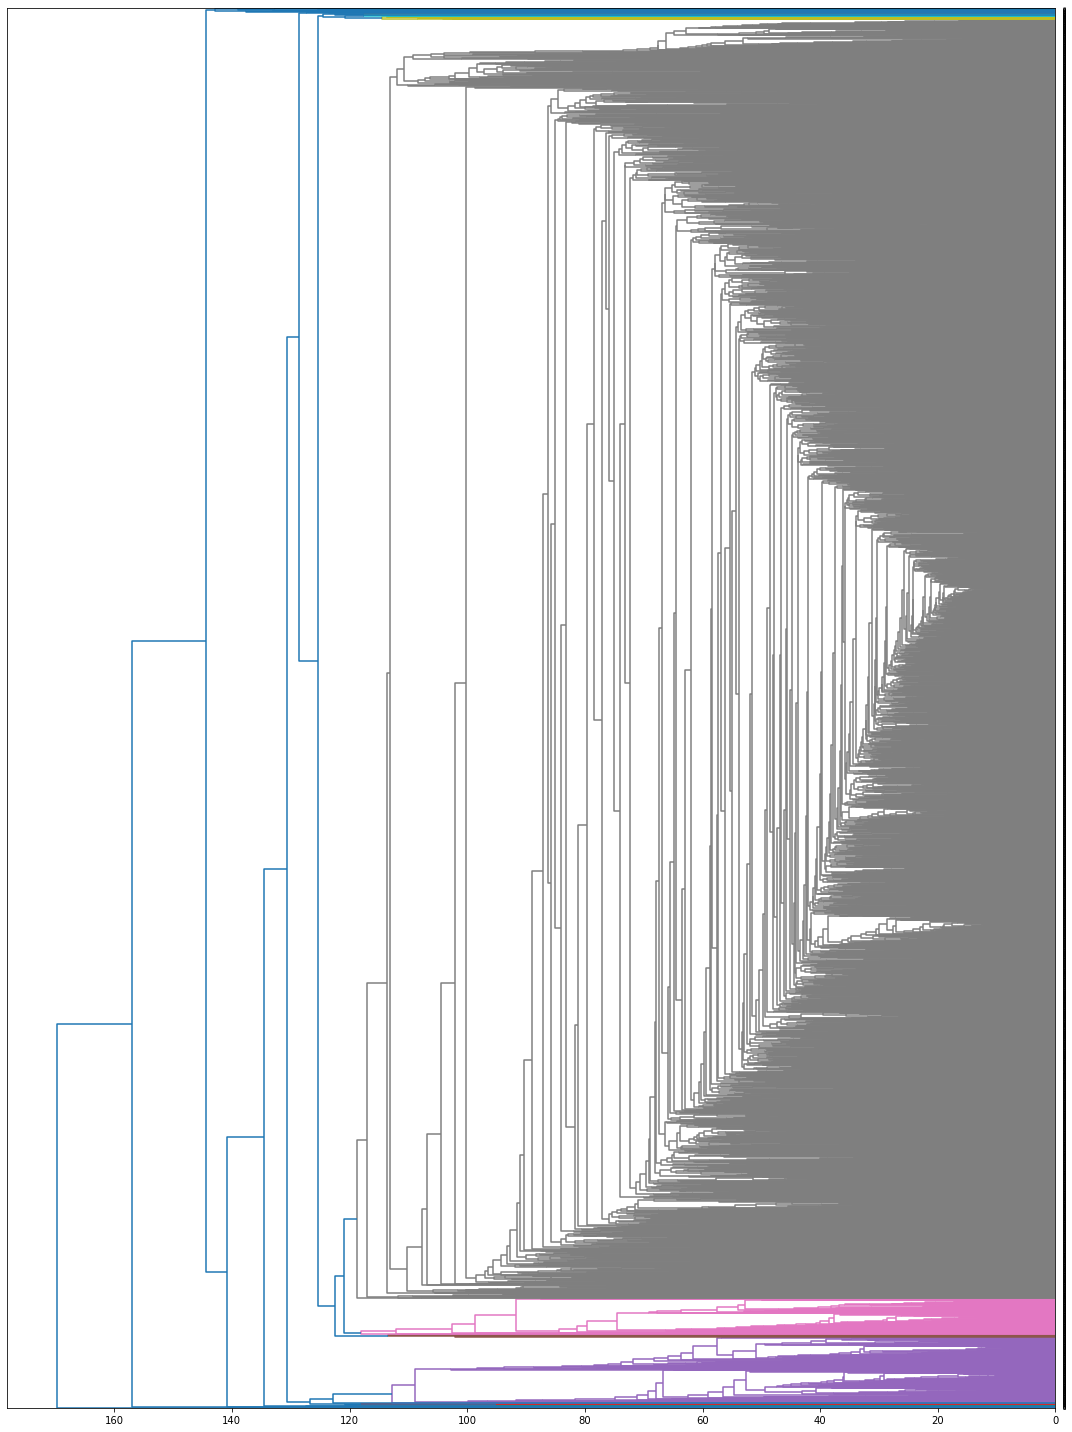

In [ ]:
# read data from CSV file
data = pd.read_csv("dailykos.csv", index_col=0)

# standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

# compute Euclidean distances
distances = pdist(data_standardized, metric="euclidean")

# convert distances to a square-form distance matrix
distance_matrix = squareform(distances)

# perform hierarchical clustering using complete linkage
clusters = linkage(distances, method="complete")

# plot dendrogram
fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(clusters, labels=data.index, orientation="left")
plt.tight_layout()
plt.show()


# Question 2

As the dataset contains 1,545 words and 3,430 observations, computing the Euclidean distances for all possible pairs of observations would require the calculation of approximately 5.6 million distances. This can be computationally expensive and time-consuming, especially if the clustering algorithm involves repeated distance calculations.

The calculation of Euclidean distances between pairs of observations requires the computation of the difference between each pair of corresponding feature values, squaring each difference, summing the squared differences, and taking the square root of the sum. This process has a computational complexity of O(n^2), where n is the number of features in the dataset.

Therefore, as the number of features and observations increase, the computation time and computational resources required to calculate pairwise distances increases exponentially. To reduce computation time, some techniques such as dimensionality reduction, feature selection or sampling can be used to reduce the number of features or observations in the dataset.

It's important to consider the practical application of the clustering results. If the goal is to provide readers with categories to choose from when deciding what to read, the number of clusters should not be so large that it becomes difficult for users to navigate or make a decision. On the other hand, it should not be so small that the categories are too broad and do not effectively capture the diversity of topics in the data.

Based on this, I would suggest starting with 5-7 clusters and evaluating the results to determine if the number of clusters needs to be adjusted.

In [ ]:
# assign observations to clusters
num_clusters = 7
cluster_labels = fcluster(clusters, num_clusters, criterion='maxclust')

# count observations in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts()

# print number of observations in cluster 3
print("Number of observations in cluster 3: ", cluster_counts[3])

# print cluster with the most observations
print("Cluster with the most observations: ", cluster_counts.idxmax())

# print cluster with the fewest observations
print("Cluster with the fewest observations: ", cluster_counts.idxmin())

Number of observations in cluster 3:  3
Cluster with the most observations:  2
Cluster with the fewest observations:  6


# Question 4

In [ ]:
# compute mean frequency values for each word in cluster 1
cluster_1_indices = [i for i, label in enumerate(cluster_labels) if label == 1]
cluster_1 = data.iloc[cluster_1_indices]
mean_freq_cluster_1 = cluster_1.mean()

# output top 6 words in cluster 1
top_6_words_cluster_1 = mean_freq_cluster_1.nlargest(6)

# print top 6 words in cluster 1
print("Top 6 words in cluster 1:")
print(top_6_words_cluster_1)


Top 6 words in cluster 1:
political     8.5
ethic         8.0
politician    8.0
response      7.0
action        6.0
act           5.5
dtype: float64


In [ ]:
# find most frequent word in cluster 1
most_frequent_word_cluster_1 = mean_freq_cluster_1.idxmax()

# print most frequent word in cluster 1
print("The most frequent word in cluster 1 is \"" + most_frequent_word_cluster_1 + "\" with an average value of " + str(mean_freq_cluster_1[most_frequent_word_cluster_1]) + ".")

The most frequent word in cluster 1 is "political" with an average value of 8.5.


# Question 5

In [ ]:
# loop through clusters
for i in range(1, num_clusters+1):
    # compute mean frequency values for each word in current cluster
    current_cluster_indices = [j for j, label in enumerate(cluster_labels) if label == i]
    current_cluster = data.iloc[current_cluster_indices]
    mean_freq_current_cluster = current_cluster.mean()

    # output top 6 words in current cluster
    top_6_words_current_cluster = mean_freq_current_cluster.nlargest(6)

    # find most frequent word in current cluster
    most_frequent_word_current_cluster = mean_freq_current_cluster.idxmax()

    # print results for current cluster
    print("Cluster ", i)
    print("Top 6 words:")
    print(top_6_words_current_cluster)
    print("Most frequent word: \"" + most_frequent_word_current_cluster + "\" with an average value of " + str(mean_freq_current_cluster[most_frequent_word_current_cluster]))
    print()


Cluster  1
Top 6 words:
political     8.5
ethic         8.0
politician    8.0
response      7.0
action        6.0
act           5.5
dtype: float64
Most frequent word: "political" with an average value of 8.5

Cluster  2
Top 6 words:
bush          2.308458
kerry         1.544044
poll          1.405034
democrat      1.404741
november      1.099502
republican    1.030729
dtype: float64
Most frequent word: "bush" with an average value of 2.308457711442786

Cluster  3
Top 6 words:
edward          9.333333
school          6.666667
america         5.666667
plan            5.666667
event           5.000000
kerryedwards    5.000000
dtype: float64
Most frequent word: "edward" with an average value of 9.333333333333334

Cluster  4
Top 6 words:
tax         6.75
deficit     6.00
income      5.75
economic    5.25
social      4.75
bush        4.50
dtype: float64
Most frequent word: "tax" with an average value of 6.75

Cluster  5
Top 6 words:
parties         14.5
democrat        11.0
dnc              

Based on the top 6 words and their frequencies, the cluster that best corresponds to the Iraq war is Cluster 6, which has the top 6 words of "fallujah", "command", "general", "iraqi", "marine", and "force".

The cluster that best corresponds to the Democratic party is Cluster 2, which has the top 6 words of "bush", "kerry", "poll", "democrat", "november", and "republican".

# Question 6

In [ ]:
# run k-means clustering
kmeans = KMeans(n_clusters=7, random_state=1000)
data_standardized = scaler.fit_transform(data)
kmeans.fit(data_standardized)

# subset data into 7 clusters
cluster_1 = data[kmeans.labels_ == 0]
cluster_2 = data[kmeans.labels_ == 1]
cluster_3 = data[kmeans.labels_ == 2]
cluster_4 = data[kmeans.labels_ == 3]
cluster_5 = data[kmeans.labels_ == 4]
cluster_6 = data[kmeans.labels_ == 5]
cluster_7 = data[kmeans.labels_ == 6]

# How many observations are in Cluster 3?
num_obs_cluster3 = len(cluster_3)
print("Number of observations in Cluster 3:", num_obs_cluster3)

# Which cluster has the most observations?
clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6, cluster_7]
num_obs = [len(c) for c in clusters]
max_num_obs_cluster = num_obs.index(max(num_obs)) + 1
print("Cluster", max_num_obs_cluster, "has the most observations with", max(num_obs), "observations.")

# Which cluster has the fewest number of observations?
min_num_obs_cluster = num_obs.index(min(num_obs)) + 1
print("Cluster", min_num_obs_cluster, "has the fewest observations with", min(num_obs), "observations.")


Number of observations in Cluster 3: 83
Cluster 4 has the most observations with 2575 observations.
Cluster 1 has the fewest observations with 1 observations.


# Question 7

In [ ]:
# output top 6 words in each cluster
for i in range(7):
    cluster_data = data[kmeans.labels_ == i]
    cluster_word_freq = cluster_data.mean(axis=0).sort_values(ascending=False)
    print(f"Cluster {i+1}")
    print("Top 6 words:")
    print(cluster_word_freq[:6])
    print(f"Most frequent word: \"{cluster_word_freq.index[0]}\" with an average value of {cluster_word_freq[0]}")
    print()


Cluster 1
Top 6 words:
year              4.0
osama             3.0
bush              3.0
terror            3.0
administration    3.0
put               2.0
dtype: float64
Most frequent word: "year" with an average value of 4.0

Cluster 2
Top 6 words:
bush          4.024904
democrat      2.459770
state         1.942529
iraq          1.931034
republican    1.630268
kerry         1.593870
dtype: float64
Most frequent word: "bush" with an average value of 4.024904214559387

Cluster 3
Top 6 words:
november     10.072289
poll          5.963855
challenge     4.096386
vote          3.662651
democrat      3.337349
house         2.457831
dtype: float64
Most frequent word: "november" with an average value of 10.072289156626505

Cluster 4
Top 6 words:
bush          1.865631
kerry         1.424854
poll          1.024854
democrat      1.012816
republican    0.690485
state         0.683107
dtype: float64
Most frequent word: "bush" with an average value of 1.865631067961165

Cluster 5
Top 6 words:
bush

 Cluster 2 has a high frequency of the word "Iraq" and "bush" and may be related to the Bush administration, which was in power during the Iraq War. It also has word "kerry", who was the Democratic nominee for president in the 2004 election, which was held during the Iraq War.
 Cluster 4 has a high frequency of the word "democrat" and "kerry" thatmay be related to the Democratic Party.


In [ ]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Compute the linkage matrix
Z = linkage(data_scaled, method='ward')

# Determine the cluster assignments
clusters = fcluster(Z, 7, criterion='maxclust')

# Save the cluster assignments to a CSV file
results = pd.DataFrame({'H_Cluster': clusters})
results.to_csv('hierarchical_results.csv')

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Read in the Daily Kos dataset
data = pd.read_csv('dailykos.csv', index_col=0)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Perform k-means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(data_scaled)

# Get the cluster assignments
clusters = kmeans.labels_

# Save the cluster assignments to a CSV file
results = pd.DataFrame({'K_Cluster': clusters})
results.to_csv('kmeans_results.csv')

import pandas as pd

# Read in the hierarchical clustering results
hierarchical_results = pd.read_csv('hierarchical_results.csv', index_col=0)

# Read in the k-means clustering results
kmeans_results = pd.read_csv('kmeans_results.csv', index_col=0)

# Create a cross tabulation table of the cluster assignments
cross_tab = pd.crosstab(hierarchical_results['H_Cluster'], kmeans_results['K_Cluster'])

# Print the cross tabulation table
print(cross_tab)


K_Cluster  0     1    2    3   4   5  6
H_Cluster                              
1          0  1906  170   25   0   0  0
2          3    14   21  178   0   3  3
3          0   212  384  180   0   2  0
4          0     0    1    0   0  81  0
5          0     0    0    0   1  78  0
6          0     0    0    0   1  79  0
7          0     0    0    2  85   1  0


K-Means Cluster 2(1 in label) has the highest number of observations in Hierarchical Cluster 1 (1906 observations). So, Hierarchical Cluster 1 best corresponds to K-Means Cluster 2.
K-Means Cluster 3(2 in label) has the highest number of observations in Hierarchical Cluster 3 (384 observations). So, Hierarchical Cluster 3 best corresponds to K-Means Cluster 3.